<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Generative adversarial networks</b></h3>



В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/MFTI/GAN/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [ ]:
DATA_DIR = './cats/'

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

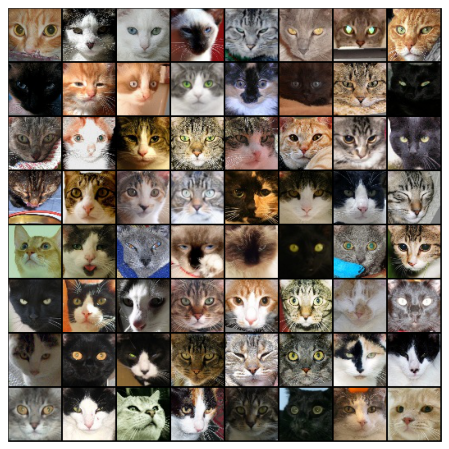

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


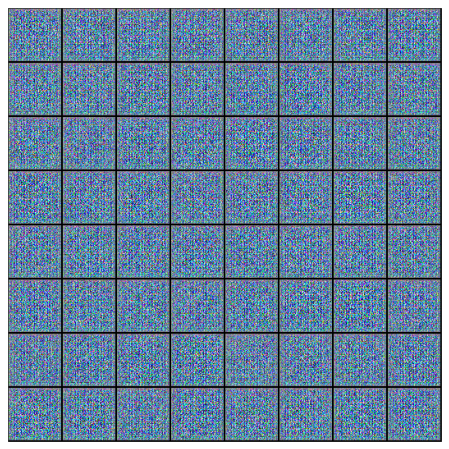

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 7.2061, loss_d: 0.3945, real_score: 0.8673, fake_score: 0.1445


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 6.4365, loss_d: 0.0500, real_score: 0.9742, fake_score: 0.0192


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 5.7579, loss_d: 0.4461, real_score: 0.8573, fake_score: 0.1319


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 4.4870, loss_d: 0.5921, real_score: 0.8141, fake_score: 0.1801


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 3.9115, loss_d: 0.7357, real_score: 0.7626, fake_score: 0.2431


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.4931, loss_d: 0.6771, real_score: 0.7802, fake_score: 0.2188


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.7857, loss_d: 0.7230, real_score: 0.7836, fake_score: 0.2154


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.6728, loss_d: 0.6772, real_score: 0.7961, fake_score: 0.2043


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.7346, loss_d: 0.6180, real_score: 0.8002, fake_score: 0.1976


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.5379, loss_d: 0.6934, real_score: 0.7912, fake_score: 0.2044


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.5546, loss_d: 0.6901, real_score: 0.7897, fake_score: 0.2129


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.3481, loss_d: 0.6621, real_score: 0.7916, fake_score: 0.2065


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.3588, loss_d: 0.6867, real_score: 0.7779, fake_score: 0.2170


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.4695, loss_d: 0.7090, real_score: 0.7776, fake_score: 0.2247


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.6531, loss_d: 0.6188, real_score: 0.8020, fake_score: 0.1992


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.4902, loss_d: 0.5749, real_score: 0.8115, fake_score: 0.1893


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.6655, loss_d: 0.5671, real_score: 0.8166, fake_score: 0.1840


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.6401, loss_d: 0.5774, real_score: 0.8197, fake_score: 0.1727


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.6918, loss_d: 0.5826, real_score: 0.8149, fake_score: 0.1827


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.7887, loss_d: 0.5588, real_score: 0.8210, fake_score: 0.1827


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.7173, loss_d: 0.4752, real_score: 0.8384, fake_score: 0.1616


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.9321, loss_d: 0.4915, real_score: 0.8409, fake_score: 0.1548


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 4.9527, loss_d: 0.4562, real_score: 0.8526, fake_score: 0.1436


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.8301, loss_d: 0.4258, real_score: 0.8524, fake_score: 0.1479


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.1124, loss_d: 0.3967, real_score: 0.8624, fake_score: 0.1364


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 5.0800, loss_d: 0.4561, real_score: 0.8551, fake_score: 0.1396


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 5.2807, loss_d: 0.4171, real_score: 0.8655, fake_score: 0.1366


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 5.5526, loss_d: 0.3684, real_score: 0.8819, fake_score: 0.1237


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 5.4006, loss_d: 0.4067, real_score: 0.8690, fake_score: 0.1221


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 5.4064, loss_d: 0.3960, real_score: 0.8770, fake_score: 0.1216


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 5.8239, loss_d: 0.3158, real_score: 0.8945, fake_score: 0.1046


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 5.7524, loss_d: 0.3735, real_score: 0.8827, fake_score: 0.1171


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 5.6811, loss_d: 0.3120, real_score: 0.8990, fake_score: 0.1011


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.6781, loss_d: 0.3791, real_score: 0.8866, fake_score: 0.1082


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 5.5733, loss_d: 0.3853, real_score: 0.8825, fake_score: 0.1145


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 6.0653, loss_d: 0.2531, real_score: 0.9181, fake_score: 0.0870


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 6.2145, loss_d: 0.3630, real_score: 0.8998, fake_score: 0.1009


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 6.1052, loss_d: 0.3050, real_score: 0.9077, fake_score: 0.0911


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 5.9578, loss_d: 0.2641, real_score: 0.9144, fake_score: 0.0857


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.0542, loss_d: 0.2781, real_score: 0.9090, fake_score: 0.0876
Saving generated-images-0040.png


Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

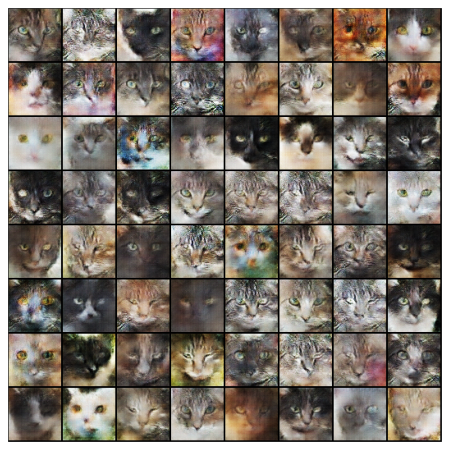

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

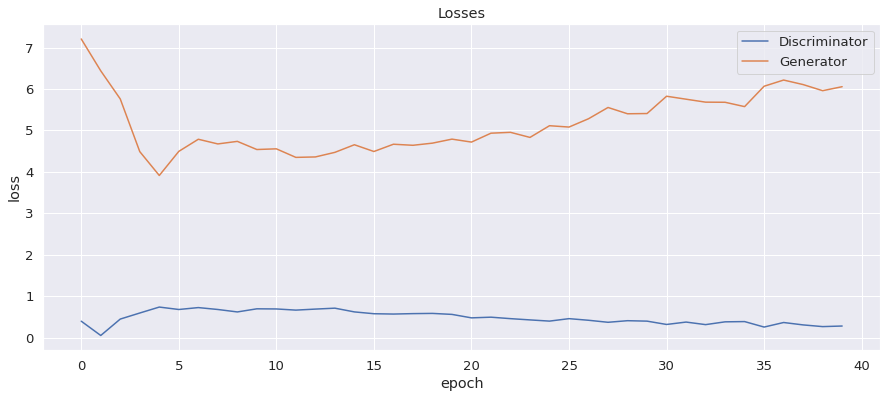

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

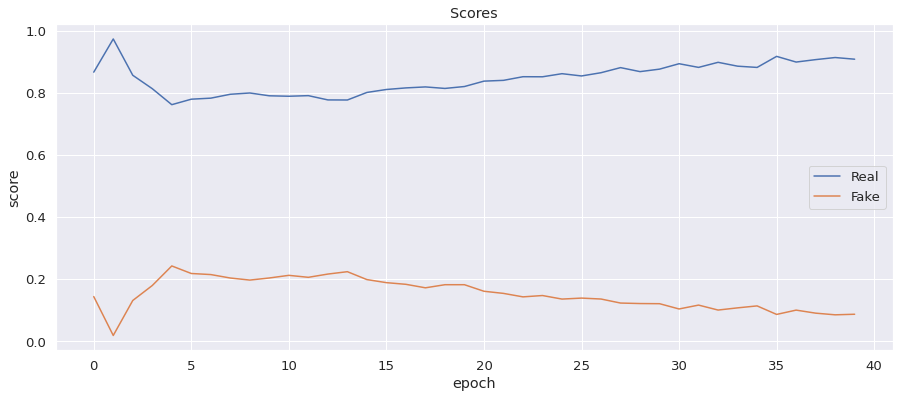

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Поведение графиков примерно такое же, как было показано на лекции